In [7]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt


이미지 전처리 정의

In [8]:
data_path='/Users/chelsey/Desktop/project/euron/8th-DL/wk4/data/catanddog/train'
transform=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
train_dataset=torchvision.datasets.ImageFolder(root=data_path,transform=transform)
train_loader=DataLoader(train_dataset,batch_size=32,num_workers=8,shuffle=True)

print(len(train_dataset))

385


MXNet이 Apple Silicon(M3)에서 호환 불가 → Pillow+PyTorch 조합으로 사용

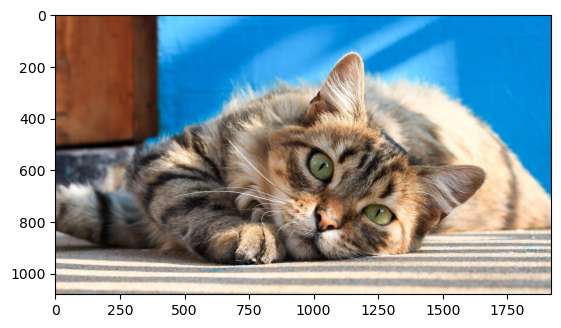

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/Users/chelsey/Desktop/project/euron/8th-DL/wk4/data/cat.jpg")
plt.imshow(img)

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

def show_images(imgs, num_rows, num_cols, scale=2):
    aspect_ratio = imgs[0].height / imgs[0].width
    figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0.1)
    return axes

def apply(img: Image.Image, aug, num_rows=2, num_cols=4, scale=3):
    augmented = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(augmented, num_rows, num_cols, scale)


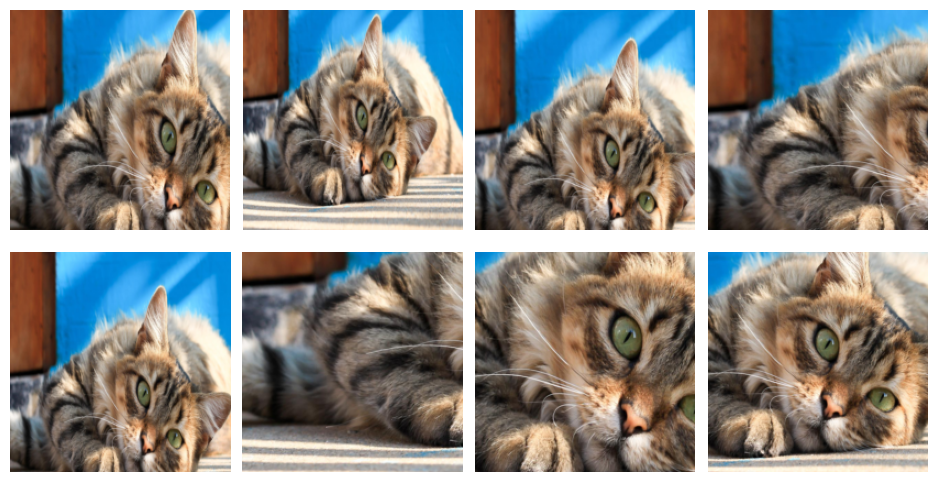

In [4]:
shape_aug = transforms.RandomResizedCrop(
    size=(200, 200),
    scale=(0.1, 1.0),
    ratio=(0.5, 2.0)
)

apply(img, shape_aug)

plt.show()

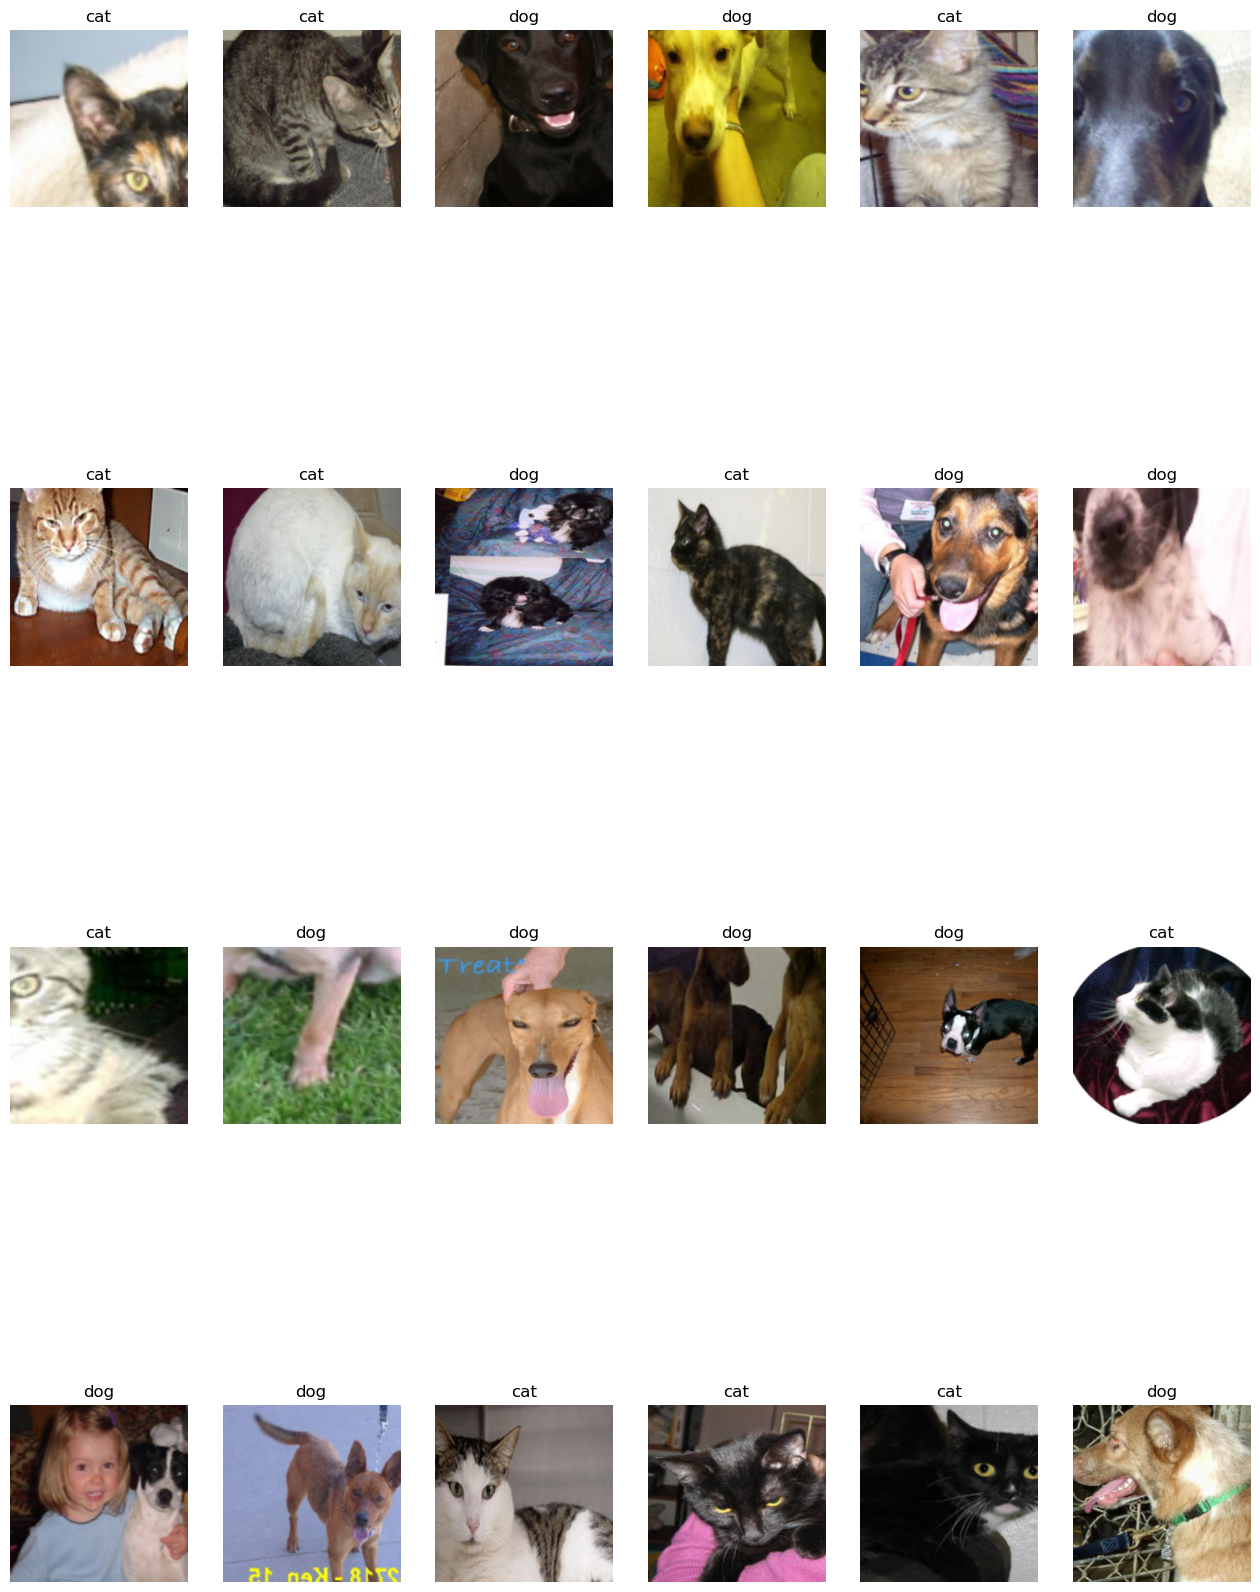

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 한 배치 가져오기
samples, labels = next(iter(train_loader))
classes = {0: 'cat', 1: 'dog'}

# 4행×6열 Figure 생성
fig, axes = plt.subplots(4, 6, figsize=(16, 24))

for i, ax in enumerate(axes.flatten()):
    # (C, H, W) → (H, W, C)로 변환 후 NumPy 배열로
    img = samples[i].permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    ax.set_title(classes[int(labels[i])])
    ax.axis('off')

plt.subplots_adjust(bottom=0.2, top=0.9, hspace=0.5)
plt.show()

In [18]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)

def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet)


In [19]:
resnet.fc=nn.Linear(512,2)

In [43]:
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

fc.weight torch.Size([2, 512])
fc.bias torch.Size([2])


In [23]:
model=models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad=False
    
model.fc=nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad=True

optimizer=torch.optim.Adam(model.parameters())
cost=torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
def train_model(model,dataloaders,criterion,optimizer, device, num_epochs=13, is_train=True):
    since=time.time()   
    acc_history=[]
    loss_history=[]
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        running_loss=0.0
        running_corrects=0
        
        for inputs, labels in dataloaders:
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,labels)
            _, preds=torch.max(outputs,1)
            loss.backward()
            optimizer.step()
            
            running_loss+=loss.item()*inputs.size(0)
            running_corrects+=torch.sum(preds==labels.data)
        epoch_loss=running_loss/len(dataloaders.dataset)
        epoch_acc = running_corrects.float() / len(dataloaders.dataset)
        
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_acc))
        if epoch_acc>best_acc:
            best_acc=epoch_acc
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(),os.path.join('/Users/chelsey/Desktop/project/euron/8th-DL/wk4','{0:0=2d}.pth'.format(epoch)))
        print()
        
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model, acc_history, loss_history

In [32]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
optimizer = optim.Adam(params_to_update)


	 fc.weight
	 fc.bias


In [34]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
criterion = nn.CrossEntropyLoss()
model, train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)


Epoch 0/12
----------


Loss: 0.2108 Acc: 0.9143

Epoch 1/12
----------
Loss: 0.2307 Acc: 0.8831

Epoch 2/12
----------
Loss: 0.1894 Acc: 0.9299

Epoch 3/12
----------
Loss: 0.2711 Acc: 0.8571

Epoch 4/12
----------
Loss: 0.2146 Acc: 0.9117

Epoch 5/12
----------
Loss: 0.1675 Acc: 0.9273

Epoch 6/12
----------
Loss: 0.1738 Acc: 0.9403

Epoch 7/12
----------
Loss: 0.2368 Acc: 0.8909

Epoch 8/12
----------
Loss: 0.1843 Acc: 0.9221

Epoch 9/12
----------
Loss: 0.2011 Acc: 0.8987

Epoch 10/12
----------
Loss: 0.1767 Acc: 0.9325

Epoch 11/12
----------
Loss: 0.2041 Acc: 0.9091

Epoch 12/12
----------
Loss: 0.1503 Acc: 0.9455

Training complete in 9m 27s
Best val Acc: 0.945455


In [40]:
from torch.utils.data import DataLoader

test_path='/Users/chelsey/Desktop/project/euron/8th-DL/wk4'
transform=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
test_dataset=torchvision.datasets.ImageFolder(root=test_path,transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)
print(len(test_dataset))


484


In [52]:
import glob
import time
import torch

def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    # 1) /Users/chelsey/Desktop/project/euron/8th-DL/wk4/*.pth 파일 목록 가져오기
    saved_models = glob.glob("/Users/chelsey/Desktop/project/euron/8th-DL/wk4/*.pth")
    saved_models.sort()  # 파일 이름 기준 정렬
    print("saved_models:", saved_models)

    # 2) 각 .pth 파일 로드 후 평가
    for model_path in saved_models:
        print("Loading model", model_path)
        
        # 모델 파라미터 로드
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)

        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # 정답 개수 누적
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0

            # 정답 개수 누적
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.float() / len(dataloaders.dataset)
        print("Acc: {:.4f}".format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print("Validation complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))

    return acc_history


In [53]:
val_acc_hist = eval_model(model, test_loader, device)

saved_models: ['/Users/chelsey/Desktop/project/euron/8th-DL/wk4/00.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/01.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/02.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/03.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/04.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/05.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/06.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/07.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/08.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/09.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/10.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/11.pth', '/Users/chelsey/Desktop/project/euron/8th-DL/wk4/12.pth']
Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/00.pth


/var/folders/7p/npc42ml14hsdz2qfn43lc51m0000gn/T/ipykernel_64655/3522718620.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Acc: 0.5062

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/01.pth
Acc: 0.4545

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/02.pth
Acc: 0.4731

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/03.pth
Acc: 0.4566

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/04.pth
Acc: 0.4773

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/05.pth
Acc: 0.4690

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/06.pth
Acc: 0.4897

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/07.pth
Acc: 0.4545

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/08.pth
Acc: 0.5227

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/09.pth
Acc: 0.4483

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/10.pth
Acc: 0.4917

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/11.pth
Acc: 0.4649

Loading model /Users/chelsey/Desktop/project/euron/8th-DL/wk4/12.pth
Acc: 0.4711

Val

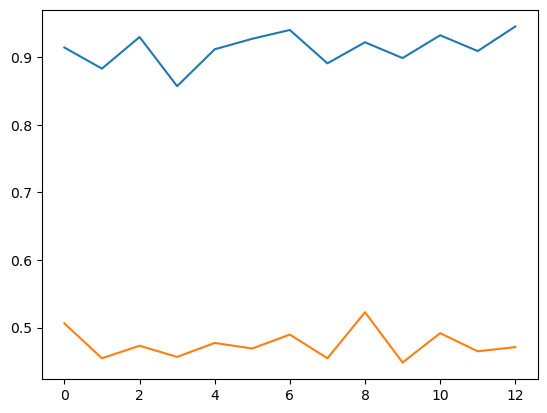

In [54]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

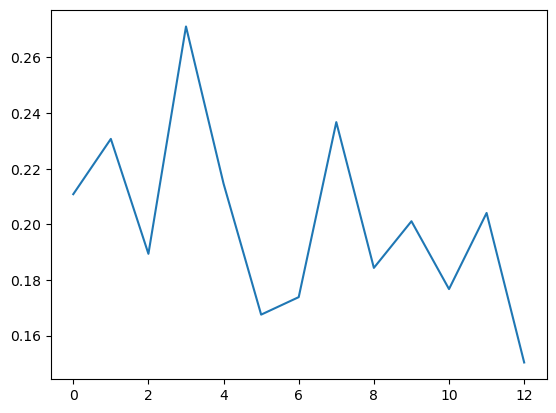

In [55]:
plt.plot(train_loss_hist)
plt.show()

In [56]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

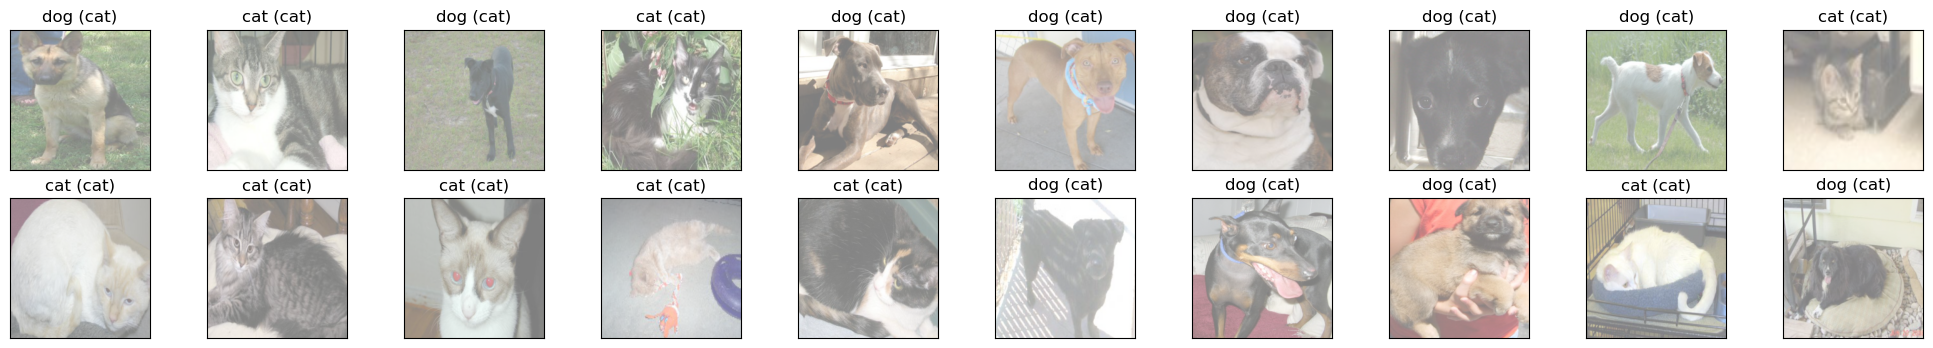

<Figure size 640x480 with 0 Axes>

In [59]:
classes={0:'cat',1:'dog'}
dataiter = iter(test_loader)
images = images.float().to(device)
labels = labels.to(device)
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()]),color=("green" if preds[idx]==labels[idx] else "red")))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [61]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [62]:
class XAI(torch.nn.Module):
    def __init__(self, model):
        super(XAI, self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,64,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64,128,3,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128,256,3,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128,128,3,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128,256,3,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256,256,3,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),   
            nn.Conv2d(256,256,3,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(256,512,3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(512,512,3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )
        self.classifier=nn.Sequential(
            nn.Linear(512,512,bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512,2)
            
        )
        
    def forward(self,x):
        x=self.features(x)
        x=x.view(-1,512)
        x=self.classifier(x)
        return F.log_softmax(x)

In [64]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
model = XAI(resnet18)
model.to(device)
model.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kerne

In [88]:
class LayerActivations:

    def __init__(self, model, layer_num):
        self.features = None
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output.detach().cpu().numpy()

        
    def remove(self):
        self.hook.remove()

torch.Size([1, 3, 100, 100])


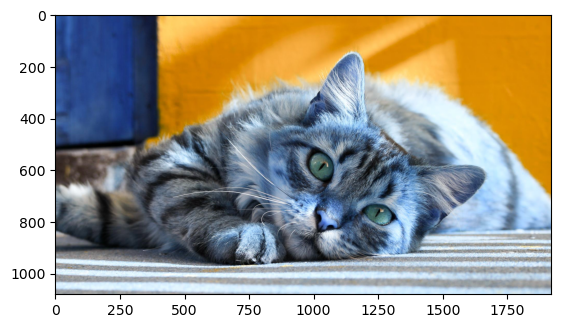

In [86]:
img=cv2.imread("/Users/chelsey/Desktop/project/euron/8th-DL/wk4/data/cat.jpg")
plt.imshow(img)
img=cv2.resize(img,(100,100),interpolation=cv2.INTER_LINEAR)
img=ToTensor()(img).unsqueeze(0)
print(img.shape)

In [89]:
img = img.to(device)
result=LayerActivations(model.features,0)
output = model(img)

# hook을 통해 저장된 activations 가져오기
activations = result.features
print("Activations shape:", activations.shape if activations is not None else "None")

# hook 제거 (선택 사항)
result.remove()

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

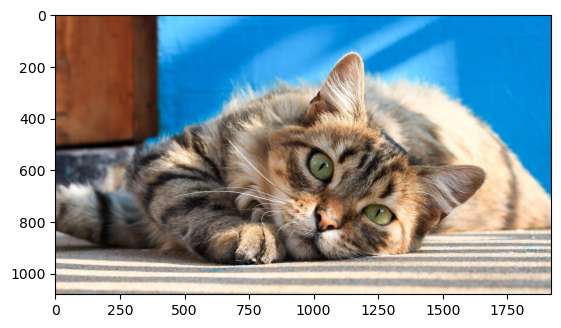

Input tensor shape: torch.Size([1, 3, 100, 100])
Number of layers in model.features: 52
Activations shape: (1, 256, 24, 24)


In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

# 디바이스 설정 (mps 또는 cpu)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# 수정된 XAI 클래스 (두 번째 버전을 기반으로, 채널 불일치 해결 및 AdaptiveAvgPool2d 추가)
class XAI(nn.Module):
    def __init__(self, backbone):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            # Block 1: (3 -> 64) then (64 -> 128)
            nn.Conv2d(3, 64, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),  # 수정: 64 -> 128
            nn.MaxPool2d(2, 2),   # 100 -> 50
            
            # Block 2: Expand then reduce: (128 -> 256 -> 128)
            nn.Conv2d(128, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),  # 수정: 128 -> 256
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 128, 3, padding=1, bias=False),  # 축소: 256 -> 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # 50 -> 25
            
            # Block 3: (128 -> 256) 유지
            nn.Conv2d(128, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),   
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # 25 -> 12
            
            # Block 4: (256 -> 512) 유지
            nn.Conv2d(256, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # 12 -> 6
            
            # Block 5: (512 -> 512) 유지
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # 6 -> 3
            
            # Adaptive pooling to get 1x1 spatial dimensions
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # (batch, 512)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# 사전학습된 resnet18 (인자로 전달하지만 내부에서는 사용하지 않음)
resnet18 = models.resnet18(pretrained=True)
model = XAI(resnet18).to(device)
model.eval()

# LayerActivations 클래스 (hook 함수: 출력 텐서를 CPU로 옮겨 NumPy 배열로 변환)
class LayerActivations:
    def __init__(self, model, layer_num):
        self.features = None
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output.detach().cpu().numpy()
        
    def remove(self):
        self.hook.remove()

# 이미지 불러오기 및 전처리
img = cv2.imread("/Users/chelsey/Desktop/project/euron/8th-DL/wk4/data/cat.jpg")
# OpenCV는 BGR이므로 RGB로 변환
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 이미지 크기 조정 (100x100) 및 텐서 변환
img_rgb = cv2.resize(img_rgb, (100, 100), interpolation=cv2.INTER_LINEAR)
img_tensor = ToTensor()(img_rgb).unsqueeze(0)  # (1, 3, 100, 100)
print("Input tensor shape:", img_tensor.shape)

# 입력 텐서를 device로 이동
img_tensor = img_tensor.to(device)

# features 내부 모듈 개수 확인 (예: 확인 후, 유효한 인덱스 사용)
print("Number of layers in model.features:", len(model.features))

# Hook 등록: model.features의 유효한 인덱스 (예, 20)
result = LayerActivations(model.features, 20)

# 모델 추론 (forward)
output = model(img_tensor)

# Hook을 통해 저장된 activations 가져오기
activations = result.features
print("Activations shape:", activations.shape if activations is not None else "None")

# Hook 제거
result.remove()


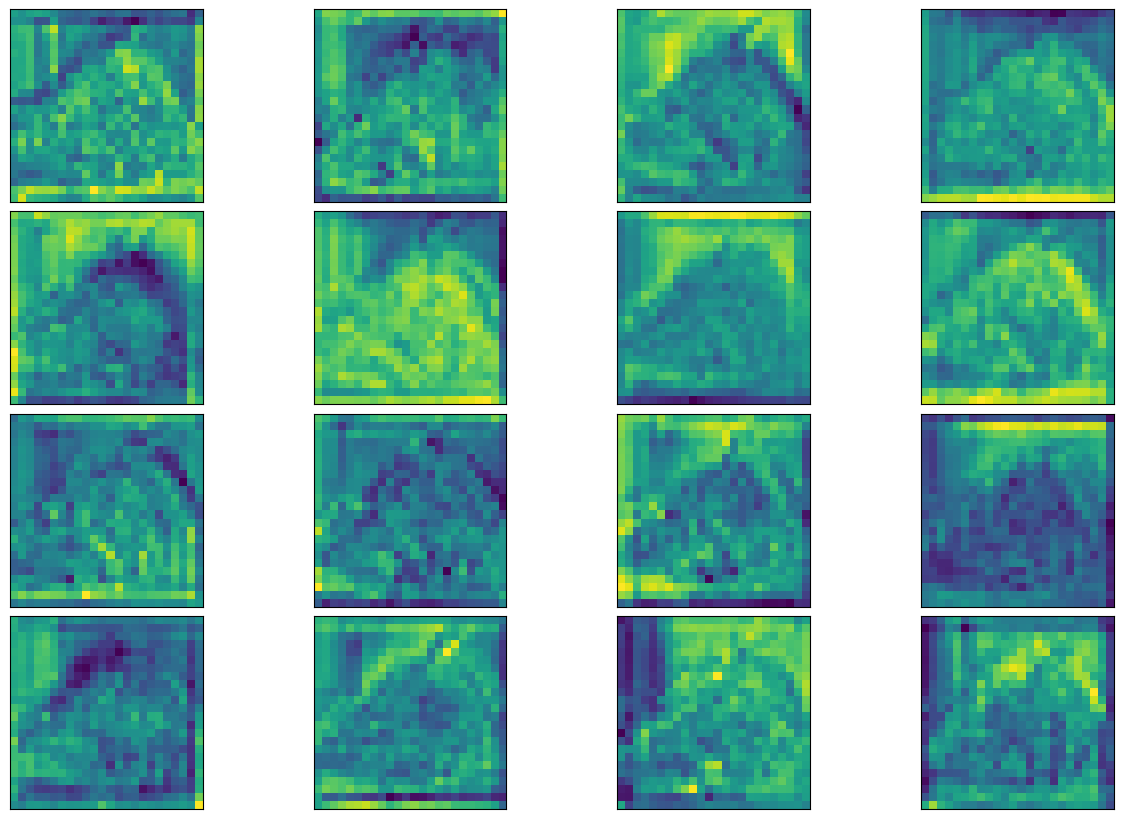

In [102]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for col in range(4):
        axis = axes[row][col]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*4 + col])
plt.show()


In [103]:
result = LayerActivations(model.features, 40)

# 모델 추론 (forward)
output = model(img_tensor)

# Hook을 통해 저장된 activations 가져오기
activations = result.features
print("Activations shape:", activations.shape if activations is not None else "None")

# Hook 제거
result.remove()

Activations shape: (1, 512, 6, 6)


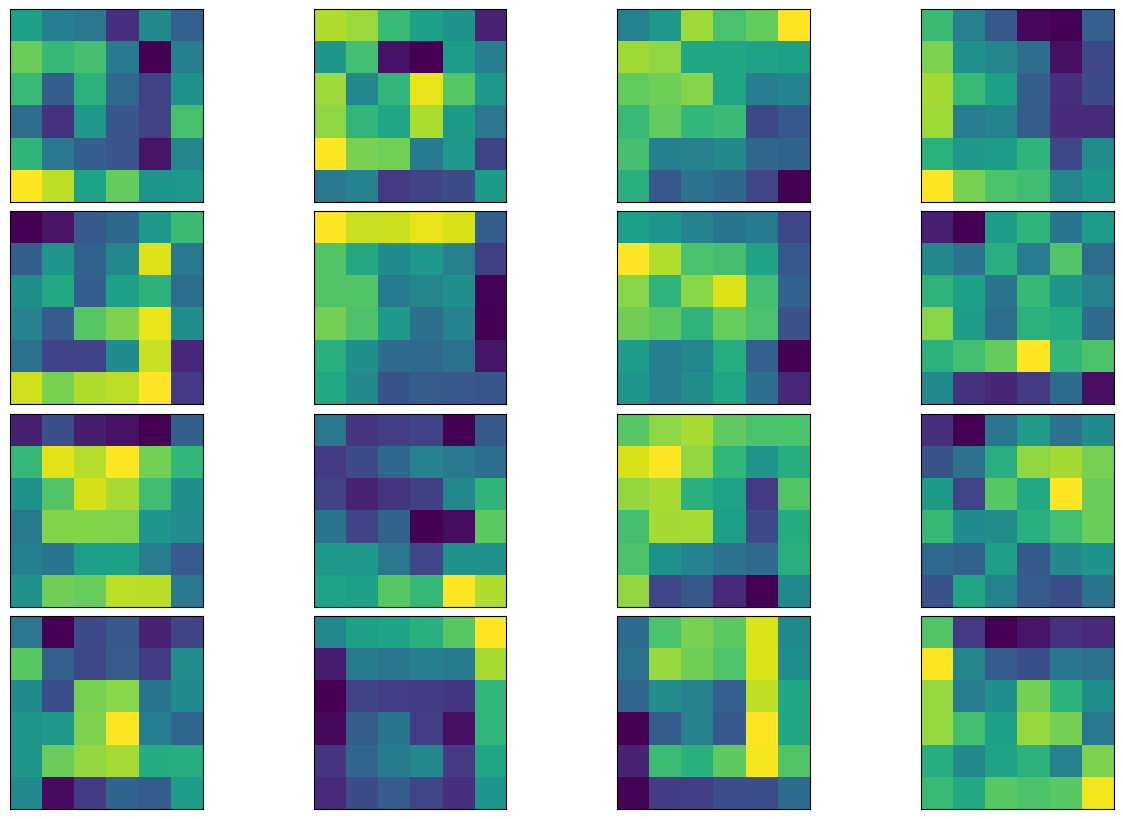

In [104]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for col in range(4):
        axis = axes[row][col]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*4 + col])
plt.show()